##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Probability 中的高斯过程回归

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/probability/examples/Gaussian_Process_Regression_In_TFP"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/Gaussian_Process_Regression_In_TFP.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/Gaussian_Process_Regression_In_TFP.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/probability/examples/Gaussian_Process_Regression_In_TFP.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

在此 Colab 中，我们将使用 TensorFlow 和 TensorFlow Probability 探索高斯过程回归。我们从一些已知函数中生成一些噪声观测值，并将 GP 模型拟合到这些数据。然后，我们从 GP 后验中采样，并将采样函数值绘制在其域中的网格上。


## 背景

假设 $\mathcal{X}$ 为任意集合。*高斯过程* (GP) 是由 $\mathcal{X}$ 索引的随机变量的集合，因此，如果 ${X_1, \ldots, X_n} \subset \mathcal{X}$ 是任意有限子集，边缘密度 $p(X_1 = x_1, \ldots, X_n = x_n)$ 为多元高斯。任何高斯分布均由其第一和第二中心矩（均值和协方差）完全指定，GP 也不例外。我们可以用它的均值函数 $\mu : \mathcal{X} \to \mathbb{R}$ 和协方差函数 $k : \mathcal{X} \times \mathcal{X} \to \mathbb{R}$ 来完全指定 GP。GP 的大部分表达能力都体现在协方差函数的选择中。由于各种原因，协方差函数也被称为*内核函数*。仅要求其对称和正定（请参阅 [Rasmussen &amp; Williams 所著图书的第 4 章](http://www.gaussianprocess.org/gpml/chapters/RW4.pdf)）。下面我们使用 ExponentiatedQuadratic 协方差内核。它的形式为：

$$ k(x, x') := \sigma^2 \exp \left( \frac{|x - x'|^2}{\lambda^2} \right) $$

其中，$\sigma^2$ 称为“幅值”，$\lambda$ 称为*长度尺度*。可以通过最大似然优化程序来选择内核参数。

来自 GP 的完整样本由整个空间 $\mathcal{X}$ 上的实值函数组成，这在实践中不切实际；通常，我们会选择一组点来观察样本，并在这些点上对函数值进行抽样。这是通过从适当的（有限维）多元高斯中进行采样来实现的。

请注意，根据上文的定义，任何有限维的多元高斯分布也是高斯过程。通常，当我们提到 GP 时，都隐含索引集为某个 $\mathbb{R}^n$，我们在这里确实会做这样的假设。

高斯过程在机器学习中的一个常见应用是高斯过程回归。其思想是，我们希望在给定有限数量的点 ${x_1, \ldots x_N}$ 处函数的噪声观测值 ${y_1, \ldots, y_N}$ 的情况下，估算出未知函数。我们想象一个生成式过程：

$$ \begin{align} f \sim : &amp; \textsf{GaussianProcess}\left( \text{mean_fn}=\mu(x), \text{covariance_fn}=k(x, x')\right) \ y_i \sim : &amp; \textsf{Normal}\left( \text{loc}=f(x_i), \text{scale}=\sigma\right), i = 1, \ldots, N \end{align} $$

如上所述，采样函数无法计算，因为我们需要它在无穷多个点处的值。因此，我们可以考虑从多元高斯中抽取有限样本。

$$ \begin{gather} \begin{bmatrix} f(x_1) \ \vdots \ f(x_N) \end{bmatrix} \sim \textsf{MultivariateNormal} \left( : \text{loc}= \begin{bmatrix} \mu(x_1) \ \vdots \ \mu(x_N) \end{bmatrix} :,: \text{scale}= \begin{bmatrix} k(x_1, x_1) &amp; \cdots &amp; k(x_1, x_N) \ \vdots &amp; \ddots &amp; \vdots \ k(x_N, x_1) &amp; \cdots &amp; k(x_N, x_N) \ \end{bmatrix}^{1/2} : \right) \end{gather} \ y_i \sim \textsf{Normal} \left( \text{loc}=f(x_i), \text{scale}=\sigma \right) $$

请注意协方差矩阵上的指数 $\frac{1}{2}$：这表示 Cholesky 分解。必须计算 Cholesky，因为 MVN 是一个位置尺度系列分布。不幸的是，Cholesky 分解的计算开销巨大，需要花费 $O(N^3)$ 的时间和 $O(N^2)$ 的空间。许多 GP 文献都集中在处理这个看似无害的小指数上。

常见的做法是将先验均值函数设为常量，通常为零。此外，某些记法约定也很方便。我们通常用 $\mathbf{f}$ 表示采样函数值的有限向量。将 $k$ 应用于输入对时，生成的协方差矩阵使用了许多有趣的表示法。根据 [(Quiñonero-Candela, 2005)](http://www.jmlr.org/papers/volume6/quinonero-candela05a/quinonero-candela05a.pdf)，我们注意到矩阵的分量是特定输入点上函数值的协方差。因此，我们可以将协方差矩阵表示为 $K_{AB}$，其中 $A$ 和 $B$ 是沿给定矩阵维度的函数值集合的一些指标。

例如，在给定观测数据 $(\mathbf{x}, \mathbf{y})$ 和隐函数值 $\mathbf{f}$ 的情况下，我们可以编写为：

$$ K_{\mathbf{f},\mathbf{f}} = \begin{bmatrix} k(x_1, x_1) &amp; \cdots &amp; k(x_1, x_N) \ \vdots &amp; \ddots &amp; \vdots \ k(x_N, x_1) &amp; \cdots &amp; k(x_N, x_N) \ \end{bmatrix} $$

同样，我们可以混合多组输入，例如：

$$ K_{\mathbf{f},<em data-md-type="emphasis">} = \begin{bmatrix} k(x_1, x^</em>_1) &amp; \cdots &amp; k(x_1, x^<em data-md-type="emphasis">_T) \ \vdots &amp; \ddots &amp; \vdots \ k(x_N, x^</em>_1) &amp; \cdots &amp; k(x_N, x^*_T) \ \end{bmatrix} $$

其中，我们假设有 $N$ 个训练输入和 $T$ 个测试输入。因此，可以将上面的生成式过程紧凑地编写为：

$$ \begin{align} \mathbf{f} \sim : &amp; \textsf{MultivariateNormal} \left( \text{loc}=\mathbf{0}, \text{scale}=K_{\mathbf{f},\mathbf{f}}^{1/2} \right) \ y_i \sim : &amp; \textsf{Normal} \left( \text{loc}=f_i, \text{scale}=\sigma \right), i = 1, \ldots, N \end{align} $$

第一行中的采样运算会从多元高斯生成一组有限的 $N$ 函数值，*而不是上面 GP 抽样表示法中的整个函数*。第二行描述了从*一元*高斯抽样的 $N$ 的集合，它们以各种函数值为中心，具有固定的观测噪声 $\sigma^2$。

借助上述生成式模型，我们就可以继续考虑后验推断问题。这将以上述过程中观测的噪声数据为条件，产生函数值在一组新的测试点上的后验分布。

借助上面的表示法，我们就可以根据相应的输入和训练数据，紧凑地编写未来（噪声）观测值的后验预测分布，如下所示（有关详情，请参阅 [Rasmussen &amp; Williams](http://www.gaussianprocess.org/gpml/) 所著图书的第 2.2 节）。

$$ \mathbf{y}^* \mid \mathbf{x}^<em data-md-type="emphasis">, \mathbf{x}, \mathbf{y} \sim \textsf{Normal} \left( \text{loc}=\mathbf{\mu}^</em>, \text{scale}=(\Sigma^*)^{1/2} \right), $$

其中

$$ \mathbf{\mu}^* = K_{*,\mathbf{f}}\left(K_{\mathbf{f},\mathbf{f}} + \sigma^2 I \right)^{-1} \mathbf{y} $$

且

$$ \Sigma^* = K_{<em data-md-type="emphasis">,</em>} - K_{<em data-md-type="emphasis">,\mathbf{f}} \left(K_{\mathbf{f},\mathbf{f}} + \sigma^2 I \right)^{-1} K_{\mathbf{f},</em>} $$

## 导入

In [ ]:
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from mpl_toolkits.mplot3d import Axes3D
%pylab inline
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

Populating the interactive namespace from numpy and matplotlib


## 示例：噪声正弦数据上的精确 GP 回归

在这里，我们从存在噪声的正弦曲线中生成训练数据，然后从 GP 回归模型的后验中采样一组曲线。我们使用 [Adam](https://arxiv.org/abs/1412.6980) 来优化内核超参数（将先验下数据的负对数似然最小化）。我们绘制训练曲线，然后是真实函数和后验样本。

In [ ]:
def sinusoid(x):
  return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_training_points, observation_noise_variance):
  """Generate noisy sinusoidal observations at a random set of points.

  Returns:
     observation_index_points, observations
  """
  index_points_ = np.random.uniform(-1., 1., (num_training_points, 1))
  index_points_ = index_points_.astype(np.float64)
  # y = f(x) + noise
  observations_ = (sinusoid(index_points_) +
                   np.random.normal(loc=0,
                                    scale=np.sqrt(observation_noise_variance),
                                    size=(num_training_points)))
  return index_points_, observations_

In [ ]:
# Generate training data with a known noise level (we'll later try to recover
# this value from the data).
NUM_TRAINING_POINTS = 100
observation_index_points_, observations_ = generate_1d_data(
    num_training_points=NUM_TRAINING_POINTS,
    observation_noise_variance=.1)

我们会将先验放在内核超参数上，然后使用 `tfd.JointDistributionNamed` 编写超参数和观测数据的联合分布。

In [ ]:
def build_gp(amplitude, length_scale, observation_noise_variance):
  """Defines the conditional dist. of GP outputs, given kernel parameters."""

  # Create the covariance kernel, which will be shared between the prior (which we
  # use for maximum likelihood training) and the posterior (which we use for
  # posterior predictive sampling)
  kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

  # Create the GP prior distribution, which we will use to train the model
  # parameters.
  return tfd.GaussianProcess(
      kernel=kernel,
      index_points=observation_index_points_,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})

我们可以通过验证是否能够从先验中进行采样，以及是否能够计算样本的对数密度，对我们的实现进行健全性检查。

In [ ]:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)

print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp))

sampled {'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=2.067952217184325>, 'length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=1.154435715487831>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=5.383850737703549>, 'observations': <tf.Tensor: shape=(100,), dtype=float64, numpy=
array([-2.37070577, -2.05363838, -0.95152824,  3.73509388, -0.2912646 ,
        0.46112342, -1.98018513, -2.10295857, -1.33589756, -2.23027226,
       -2.25081374, -0.89450835, -2.54196452,  1.46621647,  2.32016193,
        5.82399989,  2.27241034, -0.67523432, -1.89150197, -1.39834474,
       -2.33954116,  0.7785609 , -1.42763627, -0.57389025, -0.18226098,
       -3.45098732,  0.27986652, -3.64532398, -1.28635204, -2.42362875,
        0.01107288, -2.53222176, -2.0886136 , -5.54047694, -2.18389607,
       -1.11665628, -3.07161217, -2.06070336, -0.84464262,  1.29238438,
       -0.64973999, -2.63805504, -3.93317576,  0.65546645,  2.24721181,
       -0.73403676,  5.31628298

现在，我们来进行优化，以找到具有最高后验概率的参数值。我们将为每个参数定义一个变量，并将它们的值约束为正值。

In [ ]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       observation_noise_variance_var]]

为了使模型符合我们的观测数据，我们将定义一个 `target_log_prob` 函数，该函数采用（仍待推断）内核超参数。

In [ ]:
def target_log_prob(amplitude, length_scale, observation_noise_variance):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': observations_
  })

In [ ]:
# Now we optimize the model parameters.
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var,
                            observation_noise_variance_var)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = train_model()
  lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Trained parameters:
amplitude: 0.9176153445125278
length_scale: 0.18444082442910079
observation_noise_variance: 0.0880273312850989


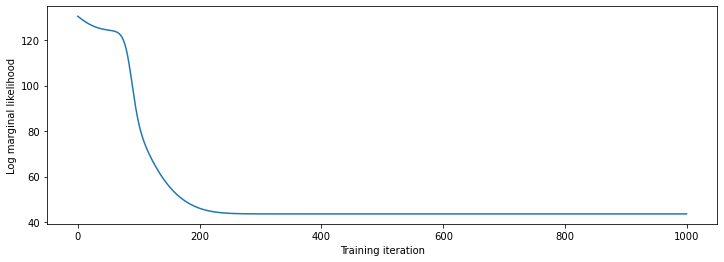

In [ ]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

In [ ]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples = gprm.sample(num_samples)

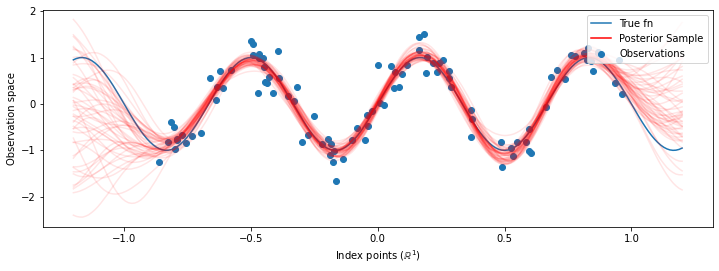

In [ ]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

*注：如果您多次运行上面的代码，有时效果会很好，有时效果会很糟！参数的最大似然训练非常敏感，并且有时会收敛到较差的模型。最好的方式是使用 MCMC 来边缘化模型超参数。*

## 使用 HMC 边缘化超参数

与其优化超参数，不如尝试用汉密尔顿蒙特卡洛对它们积分。我们首先定义并运行一个采样器，在给定观测值的情况下，从内核超参数的后验分布中进行抽样。

In [ ]:
num_results = 100
num_burnin_steps = 50

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob,
        step_size=tf.cast(0.1, tf.float64)),
    bijector=[constrain_positive, constrain_positive, constrain_positive])

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=tf.cast(0.75, tf.float64))

initial_state = [tf.cast(x, tf.float64) for x in [1., 1., 1.]]

In [ ]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, jit_compile=False)
def do_sampling():
  return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=lambda current_state, kernel_results: kernel_results)

t0 = time.time()
samples, kernel_results = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Inference ran in 9.00s.


我们通过检查超参数轨迹来对采样器进行健全性检查。 

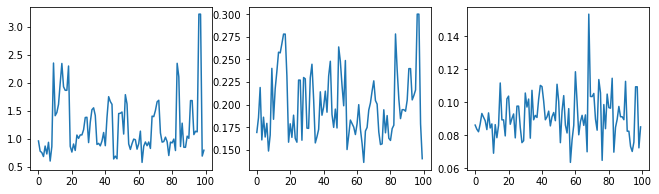

In [ ]:
(amplitude_samples,
 length_scale_samples,
 observation_noise_variance_samples) = samples

f = plt.figure(figsize=[15, 3])
for i, s in enumerate(samples):
  ax = f.add_subplot(1, len(samples) + 1, i + 1)
  ax.plot(s)

现在，我们不是使用优化的超参数来构造单个 GP，而是将*后验预测分布*构造为一个 GP 的混合，每个 GP 均由超参数的后验分布中的样本定义。这种方式通过蒙特卡洛采样对后验参数进行近似积分，以计算未观测位置的边缘预测分布。

In [ ]:
# The sampled hyperparams have a leading batch dimension, `[num_results, ...]`,
# so they construct a *batch* of kernels.
batch_of_posterior_kernels = tfk.ExponentiatedQuadratic(
    amplitude_samples, length_scale_samples)

# The batch of kernels creates a batch of GP predictive models, one for each
# posterior sample.
batch_gprm = tfd.GaussianProcessRegressionModel(
    kernel=batch_of_posterior_kernels,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_samples,
    predictive_noise_variance=0.)

# To construct the marginal predictive distribution, we average with uniform
# weight over the posterior samples.
predictive_gprm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(logits=tf.zeros([num_results])),
    components_distribution=batch_gprm)

num_samples = 50
samples = predictive_gprm.sample(num_samples)

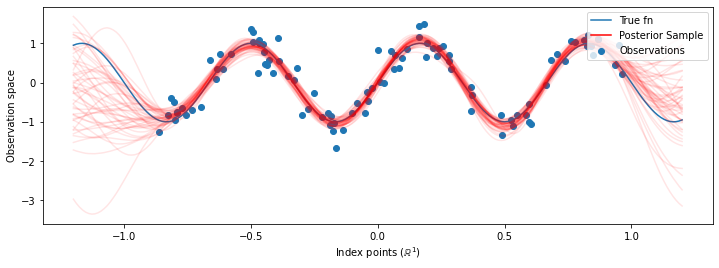

In [ ]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

尽管在这种情况下差异很细微，但总的来说，比起上面仅使用最有可能的参数的做法，我们希望后验预测分布能够更好地泛化（为保留的数据提供更高的可能性）。